# Базы данных: финальный проект

Критерии проекта:

1. CRUD
2. Where с объединением трёх таблиц в where
3. Вложенный select
4. Join
5. Агрегация
6. Триггеры, процедуры
7. Красивая структура БД
8. Связанное решение в серверной sql-базе данных
9. Скрипт с запросами
10. Docker

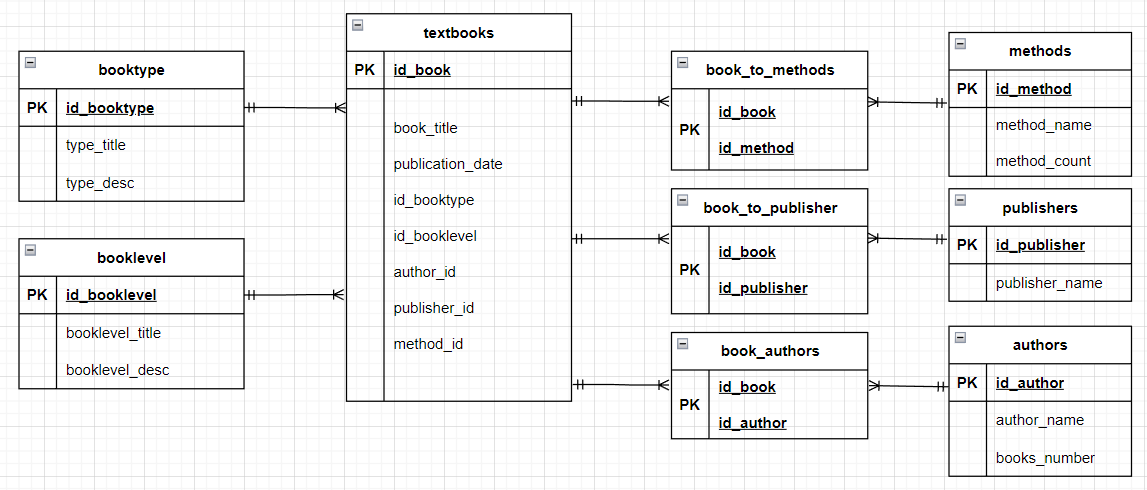

In [1]:
!pip install mysql-connector-python

In [2]:
import re
import time
import random
import requests
import pandas as pd
import mysql.connector

from bs4 import BeautifulSoup
from tqdm.auto import tqdm

session = requests.session()

import sqlite3
import pandas as pd

In [3]:
with open('mysql_password.txt', 'r', encoding='utf-8') as f:
    pwd = f.read().strip()

In [4]:
con = mysql.connector.connect(host='127.0.0.1', port=3306,
                              user='root', password=pwd)
cur = con.cursor(dictionary=True)

#cur.execute("""DROP SCHEMA IF EXISTS textbooks""")
#con.commit()

cur.execute("""
CREATE SCHEMA IF NOT EXISTS textbooks DEFAULT CHARACTER SET utf8
""")
con = mysql.connector.connect(host='127.0.0.1', port=3306,
                              database='textbooks', user='root',
                              password=pwd)
cur = con.cursor(dictionary=True, buffered=True)

In [5]:
conn = sqlite3.connect('textbooks.db')
cursor = conn.cursor()

# Данные


## type, level

У каждого из наших учебников есть тип (учебник/рабочая тетрадь/справочник по грамматике/книга для учителя) и уровень (A, B, С).
В этих таблицах не появится новых данных, их можно ввести внучную.

В каждой из этих таблиц есть три колонки:


*   уникальный id
*   название
*   описание




In [6]:
import sqlite3
import pandas as pd


# Создаём и заполняем таблицу "level" 
cursor.execute('''
    CREATE TABLE IF NOT EXISTS booktype (
        id_booktype INTEGER PRIMARY KEY,
        type_title TEXT NOT NULL,
        type_desc TEXT
    )
''')


type_data = [
    ('SB', 'Student books for training and exercises. Usually related to the textbook (tag TB) and used as addition for it for a homework.'),
    ('TB', 'Textbooks. Used as the main material for language learning in classroom.'),
    ('GR', 'Grammar explanation and exercises. May be used for self-preparation.'),
    ('ANS', 'Answers or teachers materials.')
]
cursor.executemany("INSERT INTO booktype (type_title, type_desc) VALUES (?, ?)", type_data)


conn.commit()


conn = sqlite3.connect('textbooks.db')


type_query = "SELECT * FROM booktype"
type_df = pd.read_sql_query(type_query, conn)


print(type_df)

   id_booktype type_title                                          type_desc
0            1         SB  Student books for training and exercises. Usua...
1            2         TB  Textbooks. Used as the main material for langu...
2            3         GR  Grammar explanation and exercises. May be used...
3            4        ANS                     Answers or teachers materials.


In [7]:
conn = sqlite3.connect('textbooks.db')
cursor = conn.cursor()

# Создаём и заполняем таблицу "level" 
cursor.execute('''
    CREATE TABLE IF NOT EXISTS booklevel (
        id_booklevel INTEGER PRIMARY KEY,
        booklevel_title TEXT NOT NULL,
        booklevel_desc TEXT
    )
''')

booklevel_data = [
    ('A', 'Basic user'),
    ('B', 'Independent user'),
    ('C', 'Proficient user')
]

cursor.executemany("INSERT INTO booklevel (booklevel_title, booklevel_desc) VALUES (?, ?)", booklevel_data)


conn.commit()

In [8]:
level_query = "SELECT * FROM booklevel"
level_df = pd.read_sql_query(level_query, conn)
level_df

,id_booklevel,booklevel_title,booklevel_desc
0,1,A,Basic user
1,2,B,Independent user
2,3,C,Proficient user


## **authors**

У каждого автора есть свой id, имя и количество его/её книг, которые содержатся в базе.




In [109]:
import csv
import sqlite3

# Создаём и заполняем таблицу "authors" 
conn = sqlite3.connect('textbooks.db')
cursor = conn.cursor()

# список авторов находится в одельном датасете
with open('authors.csv', 'r') as file:
    reader = csv.reader(file, delimiter=';')
    authors_data = list(reader)


cursor.execute("DROP TABLE IF EXISTS authors")


cursor.execute('''
    CREATE TABLE authors (
        id_author INTEGER PRIMARY KEY AUTOINCREMENT,
        author_name TEXT,
        books_count INTEGER DEFAULT 1
    )
''')


for author_row in authors_data:
    names = author_row[0].split(',')
    for name in names:
        name = name.strip()
        existing_author = cursor.execute("SELECT id_author FROM authors WHERE author_name = ?", (name,)).fetchone()
        if existing_author:
            cursor.execute("UPDATE authors SET books_count = books_count + 1 WHERE id_author = ?", (existing_author[0],))
        else:
            cursor.execute("INSERT INTO authors (author_name) VALUES (?)", (name,))
conn.commit()

In [112]:
conn = sqlite3.connect('textbooks.db')
cursor = conn.cursor()
a_query = "SELECT * FROM authors"
a_df = pd.read_sql_query(a_query, conn)
a_df

,id_author,author_name,books_count
0,1,Author,1
1,2,Anne Buscha,10
2,3,Szilvia Szita,10
3,4,Hartmut Aufderstra?e,3
4,5,Heiko Bock,3
5,6,Mechthild Gerdes,3
6,7,Jutta M?ller,3
7,8,Helmut M?lle,3
8,9,Charlotte Habersack,4
9,10,Angela Pude,4


## publishers

один издатель может издать несколько книг, но одной книге обязательно соответствует один издатель

In [13]:
import csv
import sqlite3

# Создаём и заполняем таблицу "publishers" 
conn = sqlite3.connect('textbooks.db')
cursor = conn.cursor()


cursor.execute("DROP TABLE IF EXISTS publishers")


cursor.execute('''
    CREATE TABLE IF NOT EXISTS publishers (
        id_publisher INTEGER PRIMARY KEY,
        publisher_name TEXT UNIQUE
    )
''')


with open('publishers.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    next(reader)  
    for row in reader:
        publisher_name = row[0].strip()
        cursor.execute("INSERT OR IGNORE INTO publishers (publisher_name) VALUES (?)", (publisher_name,))
        
        
conn.commit()

In [113]:
conn = sqlite3.connect('textbooks.db')
cursor = conn.cursor()
publishers_query = "SELECT * FROM publishers"
publishers_df = pd.read_sql_query(publishers_query, conn)
publishers_df

,id_publisher,publisher_name
0,1,Schubert Verlag
1,2,Hueber
2,3,Goethe-Institut
3,4,AST
4,5,KARO
5,6,Ernst Klett Verlag


# methods

методов у книги может быть много, книг, относящихся к одному методу - тоже

Для методов счиаем, к каким книгам он относится, количество методов в датасете.


In [16]:
# Создаём и заполняем таблицу "methods" 
with open('methods.csv', 'r') as file:
    reader = csv.reader(file, delimiter=';')
    methods_data = list(reader)


conn = sqlite3.connect('textbooks.db')
cursor = conn.cursor()


cursor.execute("DROP TABLE IF EXISTS methods")


cursor.execute('''
    CREATE TABLE methods (
        id_method INTEGER PRIMARY KEY AUTOINCREMENT,
        method_name TEXT,
        method_count INTEGER DEFAULT 1
    )
''')


for method_row in methods_data:
    names = method_row[0].split(',')
    for name in names:
        name = name.strip()
        existing_method = cursor.execute("SELECT id_method FROM methods WHERE method_name = ?", (name,)).fetchone()
        if existing_method:
            cursor.execute("UPDATE methods SET method_count = method_count + 1 WHERE id_method = ?", (existing_method[0],))
        else:
            cursor.execute("INSERT INTO methods (method_name) VALUES (?)", (name,))

conn.commit()

In [17]:
conn = sqlite3.connect('textbooks.db')
cursor = conn.cursor()
methods_query = "SELECT * FROM methods"
methods_df = pd.read_sql_query(methods_query, conn)
methods_df

,id_method,method_name,method_count
0,1,Methods,1
1,2,Fill in the gap,27
2,3,Communicative,18
3,4,Text comprehension,18
4,5,Writing,9
5,6,Exam Prep,7


# **Textbooks**

Для учебников нужно хранить:
* уникальный id
* название
* дата публикации
* тип
* уровень
* id автора
* id издателя
* id методик


In [23]:
# Загрузка данных из books.csv
books_df = pd.read_csv('textbooks.csv', delimiter=';')
books_df

,book_title,publication_date,id_booktype,id_booklevel,author_id,publisher_id,method_id
0,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,3,1,"2, 3",1,2
1,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,4,1,"2, 3",1,2
2,Themen aktuell 1,2003,2,1,"4, 5, 6 ,7, 8",2,"3, 2, 4, 5"
3,Menschen Deutsch als Fremdsprache Kursbuch A1,2021,2,1,"9, 10, 11",2,"3, 2, 4"
4,Menschen Deutsch als Fremdsprache Arbeitsbuch A1,2021,1,1,"9, 10, 11",2,"3, 2, 4"
5,Menschen Deutsch als Fremdsprache Kursbuch A2,2021,2,1,"9, 10, 11",2,"3, 2, 4"
6,Menschen Deutsch als Fremdsprache Arbeitsbuch A2,2021,1,1,"9, 10, 11",2,"3, 2, 4"
7,Begegnungen A1,2005,2,1,"2, 3",1,"3, 2, 4, 5"
8,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,3,2,"2, 3",1,2
9,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,4,2,"2, 3",1,2


In [71]:
cursor.execute("DROP TABLE IF EXISTS textbooks")

In [72]:
cursor.execute('''
    CREATE TABLE textbooks(
        id_book INTEGER PRIMARY KEY AUTOINCREMENT,
        book_title TEXT,
        publication_date TEXT,
        id_booktype INTEGER,
        id_booklevel INTEGER,
        author_id INTEGER,
        publisher_id INTEGER,
        method_id INTEGER,
        FOREIGN KEY (id_booktype) REFERENCES booktype (id_booktype),
        FOREIGN KEY (id_booklevel) REFERENCES booklevel (id_booklevel),
        FOREIGN KEY (author_id) REFERENCES authors (id_author),
        FOREIGN KEY (publisher_id) REFERENCES publishers (id_publisher),
        FOREIGN KEY (method_id) REFERENCES methods (id_method)               
    )
    ''') 

conn.commit()

In [73]:
conn = sqlite3.connect('textbooks.db')
cursor = conn.cursor()

# Соответствие

нам нужно связать учебники с авторами, методами и издателями

In [75]:
cursor.execute("DROP TABLE IF EXISTS book_authors")


In [83]:
cursor.execute("DROP TABLE IF EXISTS book_publishers")

In [90]:
cursor.execute("DROP TABLE IF EXISTS book_methods")

In [93]:
cursor.execute('''
    CREATE TABLE IF NOT EXISTS book_authors (
        id_book INTEGER,
        author_id INTEGER,
        FOREIGN KEY (id_book) REFERENCES textbooks (id_book),
        FOREIGN KEY (author_id) REFERENCES authors (id_author),
        PRIMARY KEY (id_book, author_id)
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS book_publishers (
        id_book INTEGER,
        publisher_id INTEGER,
        FOREIGN KEY (id_book) REFERENCES textbooks (id_book),
        FOREIGN KEY (publisher_id) REFERENCES publishers (id_publisher),
        PRIMARY KEY (id_book, publisher_id)
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS book_methods (
        id_book INTEGER,
        method_id INTEGER,
        FOREIGN KEY (id_book) REFERENCES textbooks (id_book),
        FOREIGN KEY (method_id) REFERENCES methods (id_method)
        PRIMARY KEY (id_book, method_id)
    )
''')


In [94]:
with open('textbooks.csv', 'r') as file:
    reader = csv.reader(file, delimiter=';')
    next(reader)  # Skip the header row
    for row in reader:
        book_title = row[0]
        publication_date = row[1]
        id_booktype = int(row[2])
        id_booklevel = int(row[3])
        author_ids = [int(author_id.strip()) for author_id in row[4].split(',')]       
        publisher_ids = [int(publisher_id.strip()) for publisher_id in row[5].split(',')]
        method_ids = [int(method_id.strip()) for method_id in row[6].split(',')]

        cursor.execute("INSERT INTO textbooks (book_title, publication_date, id_booktype, id_booklevel) "
                       "VALUES (?, ?, ?, ?)",
                       (book_title, publication_date, id_booktype, id_booklevel))

        id_book = cursor.lastrowid

        for author_id in author_ids:
            cursor.execute("INSERT INTO book_authors (id_book, author_id) VALUES (?, ?)",
                           (id_book, author_id))
        for publisher_id in publisher_ids:
            cursor.execute("INSERT INTO book_publishers (id_book, publisher_id) VALUES (?, ?)",
                           (id_book, publisher_id))
        for method_id in method_ids:
            cursor.execute("INSERT INTO book_methods (id_book, method_id) VALUES (?, ?)",
                           (id_book, method_id))
            
conn.commit()

In [95]:
b2a_query = "SELECT * FROM book_authors"
b2a_df = pd.read_sql_query(b2a_query, conn)
b2a_df

,id_book,author_id
0,1,2
1,1,3
2,2,2
3,2,3
4,3,2
...,...,...
61,28,13
62,29,14
63,30,15
64,31,16


In [96]:
b2p_query = "SELECT * FROM book_publishers"
b2p_df = pd.read_sql_query(b2p_query, conn)
b2p_df

,id_book,publisher_id
0,4,1
1,5,1
2,6,1
3,7,2
4,8,2
5,9,2
6,10,2
7,11,2
8,12,1
9,13,1


In [97]:
b2m_query = "SELECT * FROM book_methods"
b2m_df = pd.read_sql_query(b2m_query, conn)
b2m_df

,id_book,method_id
0,5,2
1,6,2
2,7,3
3,7,2
4,7,4
...,...,...
74,30,6
75,30,3
76,30,2
77,30,4


# Триггеры

сделаем триггеры для автоматического обновления счётчика у книг автора при добавлении новой книги

In [123]:
conn = sqlite3.connect('textbooks.db')
cursor = conn.cursor()


trigger_code = '''
CREATE TRIGGER update_author_books_count AFTER INSERT ON textbooks
FOR EACH ROW
BEGIN
  UPDATE authors SET books_count = books_count + 1 WHERE id_author = NEW.author_id;
END;
'''


cursor.execute(trigger_code)

conn.commit()

OperationalError: trigger update_author_books_count already exists

Сделаем триггер для автообновления количества методов

In [100]:
conn = sqlite3.connect('textbooks.db')
cursor = conn.cursor()

trigger_query = '''
CREATE TRIGGER IF NOT EXISTS update_method_count
AFTER INSERT ON textbooks
FOR EACH ROW
BEGIN
    UPDATE methods
    SET method_count = method_count + 1
    WHERE id_method = NEW.method_id;
END;
'''

cursor.execute(trigger_query)

conn.commit()

# Процедуры

Добавление новой книги

In [183]:
def add_book(book_title, publication_date, id_booktype, id_booklevel, author_ids, publisher_ids, method_ids):
    cursor.execute("INSERT INTO textbooks (book_title, publication_date, id_booktype, id_booklevel) "
                   "VALUES (?, ?, ?, ?)",
                   (book_title, publication_date, id_booktype, id_booklevel))
    id_book = cursor.lastrowid

    for author_id in author_ids:
        cursor.execute("INSERT INTO book_authors (id_book, author_id) VALUES (?, ?)",
                       (id_book, author_id))

    for publisher_id in publisher_ids:
        cursor.execute("INSERT INTO book_publishers (id_book, publisher_id) VALUES (?, ?)",
                       (id_book, publisher_id))

    for method_id in method_ids:
        cursor.execute("INSERT INTO book_methods (id_book, method_id) VALUES (?, ?)",
                       (id_book, method_id))

    conn.commit()

In [184]:
add_book('Delfin Lehrwerk für Deutsch als Framdsprache', '2020', 1, 1, [4, 7], [2], [2])

OperationalError: no such column: books_count

In [185]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='authors'")
table_exists = cursor.fetchone()

if table_exists:
    cursor.execute("PRAGMA table_info(authors)")
    columns = cursor.fetchall()
    column_names = [column[1] for column in columns]
    if 'books_count' in column_names:
        print("Таблица 'authors' и столбец 'books_count' существуют.")
    else:
        print("Столбец 'books_count' отсутствует в таблице 'authors'.")
else:
    print("Таблица 'authors' не существует.")

Таблица 'authors' и столбец 'books_count' существуют.


Поиск по автору

In [104]:
def search_books_by_author(author_name):
    cursor.execute("SELECT t.book_title, t.publication_date "
                   "FROM textbooks t "
                   "INNER JOIN book_authors ba ON t.id_book = ba.id_book "
                   "INNER JOIN authors a ON ba.author_id = a.id_author "
                   "WHERE a.author_name = ?",
                   (author_name,))
    books = cursor.fetchall()
    for book in books:
        print("Book Title:", book[0])
        print("Publication Date:", book[1])
        print("-----------")

In [129]:
search_books_by_author('Szilvia Szita')

Book Title: ?bungsgrammatik
Deutsch als Fremdsprache
Sprachniveau A1, A2
Publication Date: 2010
-----------
Book Title: ?bungsgrammatik
Deutsch als Fremdsprache
Sprachniveau A1, A2
Publication Date: 2010
-----------
Book Title: ?bungsgrammatik
Deutsch als Fremdsprache
Sprachniveau A1, A2
Publication Date: 2010
-----------
Book Title: ?bungsgrammatik
Deutsch als Fremdsprache
Sprachniveau A1, A2
Publication Date: 2010
-----------
Book Title: ?bungsgrammatik
Deutsch als Fremdsprache
Sprachniveau A1, A2
Publication Date: 2010
-----------
Book Title: ?bungsgrammatik
Deutsch als Fremdsprache
Sprachniveau A1, A2 L?sungsheft
Publication Date: 2010
-----------
Book Title: Begegnungen A1
Publication Date: 2005
-----------
Book Title: ?bungsgrammatik
Deutsch als Fremdsprache
Sprachniveau B1, B2
Publication Date: 2010
-----------
Book Title: ?bungsgrammatik
Deutsch als Fremdsprache
Sprachniveau B1, B2 L?sungsheft
Publication Date: 2010
-----------
Book Title: ?bungsgrammatik
Deutsch als Fremdsprac

Обновление информации

In [105]:
def update_book(id_book, new_title, new_date):
    cursor.execute("UPDATE textbooks SET book_title = ?, publication_date = ? WHERE id_book = ?",
                   (new_title, new_date, id_book))
    conn.commit()

In [132]:
update_book(2, 'Uebungsgrammatik Deutsch als Fremdsprache Sprachniveau A1, A2', '2005')

In [136]:
textbooks_query = "SELECT * FROM textbooks"
textbooks_df = pd.read_sql_query(textbooks_query, conn)
textbooks_df

,id_book,book_title,publication_date,id_booktype,id_booklevel,author_id,publisher_id,method_id
0,1,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,3,1,None,None,None
1,2,Uebungsgrammatik Deutsch als Fremdsprache Spra...,2005,3,1,None,None,None
2,3,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,3,1,None,None,None
3,4,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,3,1,None,None,None
4,5,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,3,1,None,None,None
5,6,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,4,1,None,None,None
6,7,Themen aktuell 1,2003,2,1,None,None,None
7,8,Menschen Deutsch als Fremdsprache Kursbuch A1,2021,2,1,None,None,None
8,9,Menschen Deutsch als Fremdsprache Arbeitsbuch A1,2021,1,1,None,None,None
9,10,Menschen Deutsch als Fremdsprache Kursbuch A2,2021,2,1,None,None,None


Удаление книги

In [103]:
def delete_book(id_book):
    cursor.execute("DELETE FROM textbooks WHERE id_book = ?", (id_book,))
    conn.commit()

In [137]:
delete_book(31)

In [138]:
textbooks_query = "SELECT * FROM textbooks"
textbooks_df = pd.read_sql_query(textbooks_query, conn)
textbooks_df

,id_book,book_title,publication_date,id_booktype,id_booklevel,author_id,publisher_id,method_id
0,1,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,3,1,None,None,None
1,2,Uebungsgrammatik Deutsch als Fremdsprache Spra...,2005,3,1,None,None,None
2,3,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,3,1,None,None,None
3,4,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,3,1,None,None,None
4,5,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,3,1,None,None,None
5,6,?bungsgrammatik\nDeutsch als Fremdsprache\nSpr...,2010,4,1,None,None,None
6,7,Themen aktuell 1,2003,2,1,None,None,None
7,8,Menschen Deutsch als Fremdsprache Kursbuch A1,2021,2,1,None,None,None
8,9,Menschen Deutsch als Fremdsprache Arbeitsbuch A1,2021,1,1,None,None,None
9,10,Menschen Deutsch als Fremdsprache Kursbuch A2,2021,2,1,None,None,None


## Вложенный Select, агрегация, join

Найдём среднее количество методов у каждой книги:

In [173]:
def average_books_per_publisher():
    cursor.execute("SELECT AVG(method_count) "
                   "FROM methods")
    average_books = cursor.fetchone()[0]
    print(f"The average number of methods used in a book is {average_books:.2f}")


In [174]:
average_books_per_publisher()

The average number of methods used in a book is 13.33


Поищем авторов, у которых количество книг больше среднего

In [163]:
def find_authors_with_above_average_books():
    cursor.execute("SELECT a.author_name "
                   "FROM authors a "
                   "INNER JOIN book_authors ba ON a.id_author = ba.author_id "
                   "GROUP BY a.author_name "
                   "HAVING COUNT(ba.id_book) > (SELECT AVG(books_count) FROM authors)")
    authors = cursor.fetchall()
    print("Authors with above-average books:")
    for author in authors:
        print(author[0])

In [164]:
find_authors_with_above_average_books()

Authors with above-average books:
Angela Pude
Anne Buscha
Charlotte Habersack
Franz Specht
Goethe-Institut
Szilvia Szita


Попробуем получить количество книг у кого-нибудь из авторов

In [179]:
def count_books_by_author(author_name):
    cursor.execute("SELECT COUNT(*) "
                   "FROM textbooks t "
                   "INNER JOIN book_authors ba ON t.id_book = ba.id_book "
                   "INNER JOIN authors a ON ba.author_id = a.id_author "
                   "WHERE a.author_name = ?",
                   (author_name,))
    book_count = cursor.fetchone()[0]
    print(f"The author '{author_name}' has {book_count} books.")

In [180]:
count_books_by_author('Angela Pude')

The author 'Angela Pude' has 4 books.


Надём книги, опубликованные в том же году, что и книги какого-нибудь автора

In [181]:
def search_books_same_year_as_author(author_name):
    cursor.execute("SELECT t.book_title, t.publication_date "
                   "FROM textbooks t "
                   "INNER JOIN book_authors ba ON t.id_book = ba.id_book "
                   "INNER JOIN authors a ON ba.author_id = a.id_author "
                   "WHERE a.author_name = ? "
                   "AND strftime('%Y', t.publication_date) = "
                   "(SELECT strftime('%Y', t2.publication_date) "
                   "FROM textbooks t2 "
                   "INNER JOIN book_authors ba2 ON t2.id_book = ba2.id_book "
                   "INNER JOIN authors a2 ON ba2.author_id = a2.id_author "
                   "WHERE a2.author_name = ? "
                   "LIMIT 1)",
                   (author_name, author_name))
    books = cursor.fetchall()
    for book in books:
        print("Book Title:", book[0])
        print("Publication Date:", book[1])
        print("-----------")

In [182]:
search_books_same_year_as_author('Angela Pude')

Book Title: Menschen Deutsch als Fremdsprache Kursbuch A1 
Publication Date: 2021
-----------
Book Title: Menschen Deutsch als Fremdsprache Arbeitsbuch A1 
Publication Date: 2021
-----------
Book Title: Menschen Deutsch als Fremdsprache Kursbuch A2 
Publication Date: 2021
-----------
Book Title: Menschen Deutsch als Fremdsprache Arbeitsbuch A2
Publication Date: 2021
-----------
